In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
adani_green = yf.download("ADANIGREEN.NS", "2024-05-22", "2025-05-22").reset_index()
adani_green['Date'] = pd.to_datetime(adani_green['Date'])
adani_green.columns = [col[0] for col in adani_green.columns]
adani_green = adani_green.sort_values('Date').reset_index(drop=True)

bharat_electronics_limited = yf.download("BEL.NS", "2024-05-22", "2025-05-22").reset_index()
bharat_electronics_limited.columns = [col[0] for col in bharat_electronics_limited.columns]
bharat_electronics_limited['Date'] = pd.to_datetime(bharat_electronics_limited['Date'])
bharat_electronics_limited = bharat_electronics_limited.sort_values('Date').reset_index(drop=True)

datasets = {
    'Adani Green': adani_green,
    'Bharat Electronics': bharat_electronics_limited
}

/tmp/ipython-input-2352994910.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  adani_green = yf.download("ADANIGREEN.NS", "2024-05-22", "2025-05-22").reset_index()
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2352994910.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bharat_electronics_limited = yf.download("BEL.NS", "2024-05-22", "2025-05-22").reset_index()
[*********************100%***********************]  1 of 1 completed


In [3]:
# Strategies

def ema_crossover(df):
    df = df.copy().reset_index(drop=True)

    # Ensure numeric and Series format
    close = df['Close'].astype(float)

    ema = close.ewm(span=14, adjust=False).mean()

    df['EMA'] = ema
    df['Signal'] = 0

    # Ensure alignment: close and ema are both Series with same index
    cond_buy = (close > ema) & (close.shift(1) <= ema.shift(1))
    cond_sell = (close < ema) & (close.shift(1) >= ema.shift(1))

    df.loc[cond_buy, 'Signal'] = 1
    df.loc[cond_sell, 'Signal'] = -1

    return df

def ema_dynamic_atr_band(df):
    df = df.copy().reset_index(drop=True)
    df['Close'] = df['Close'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)

    df['EMA'] = df['Close'].ewm(span=14, adjust=False).mean()
    df['Range'] = df['High'] - df['Low']

    df['BuyBand'] = df['EMA'] + df['Range']
    df['SellBand'] = df['EMA'] - df['Range']

    df['Signal'] = 0
    df.loc[df['Close'] > df['BuyBand'], 'Signal'] = 1
    df.loc[df['Close'] < df['SellBand'], 'Signal'] = -1

    return df


def compute_atr(df, period=14):
    df = df.copy()
    high = df['High'].astype(float)
    low = df['Low'].astype(float)
    close = df['Close'].astype(float)

    df['H-L'] = high - low
    df['H-PC'] = (high - close.shift()).abs()
    df['L-PC'] = (low - close.shift()).abs()
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=period).mean()
    return df['ATR']


def atr_breakout(df, k=1.5):
    df = df.copy().reset_index(drop=True)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['Close'] = df['Close'].astype(float)

    df['ATR'] = compute_atr(df)
    df['EMA'] = df['Close'].ewm(span=14, adjust=False).mean()

    df['BuyBand'] = df['EMA'] + k * df['ATR']
    df['SellBand'] = df['EMA'] - k * df['ATR']

    df['Signal'] = 0
    df.loc[df['Close'] > df['BuyBand'], 'Signal'] = 1
    df.loc[df['Close'] < df['SellBand'], 'Signal'] = -1

    return df



strategies = {
    'EMA Crossover': ema_crossover,
    'EMA Dynamic ATR Band': ema_dynamic_atr_band,
    'ATR Breakout': atr_breakout
}


In [4]:
# === Backtesting Engine ===

def backtest(df, signal_col):
    position = 0
    entry_price = 0
    quantity = 0
    capital = 100000
    portfolio_value = []
    holdings = []
    trades = []
    daily_returns = []

    for i in range(len(df)):
        signal = df.loc[i, signal_col]
        close_price = df.loc[i, 'Close']

        # entering long
        if signal == 1 and position <= 0:
            # if currently short then exit short position
            if position == -1:
                exit_price = close_price
                ret = (entry_price - exit_price) / entry_price
                trades[-1].update({
                    'Exit Index': i,
                    'Exit Date': df.loc[i, 'Date'],
                    'Trade Duration': i - trades[-1]['Entry Index'],
                    'Returns (%)': ret * 100
                })
                capital -= quantity * exit_price # buy back shares (exit short)
                quantity = 0
                position = 0
            # enter long
            entry_price = close_price
            quantity = capital // close_price
            capital -= quantity * close_price # pay to buy shares
            position = 1
            trades.append({
                'Entry Index': i,
                'Entry Date': df.loc[i, 'Date'],
                'Exit Index': None,
                'Exit Date': None,
                'Trade Duration': None,
                'Returns (%)': None,
                'Type': 'Long',
                'Quantity': quantity
            })

        # entering short
        elif signal == -1 and position >= 0:
            # if currently long then exit long position
            if position == 1:
                exit_price = close_price
                ret = (exit_price - entry_price) / entry_price
                trades[-1].update({
                    'Exit Index': i,
                    'Exit Date': df.loc[i, 'Date'],
                    'Trade Duration': i - trades[-1]['Entry Index'],
                    'Returns (%)': ret * 100
                })
                capital += quantity * exit_price  # sell shares (exit long)
                quantity = 0
                position = 0

            # enter short
            entry_price = close_price
            quantity = capital // close_price
            capital += quantity * close_price  # proceeds from short sale
            position = -1
            trades.append({
                'Entry Index': i,
                'Entry Date': df.loc[i, 'Date'],
                'Exit Index': None,
                'Exit Date': None,
                'Trade Duration': None,
                'Returns (%)': None,
                'Type': 'Short',
                'Quantity': quantity
            })

        if position == 1:
            pv = capital + quantity * close_price
        elif position == -1:
            pv = capital + quantity * (entry_price - close_price)
        else:
            pv = capital

        portfolio_value.append(pv)
        holdings.append(quantity)

        if i > 0:
            daily_returns.append((pv - portfolio_value[-2]) / portfolio_value[-2])
        else:
            daily_returns.append(0)

    if position != 0:
        i = len(df) - 1
        close_price = df.loc[i, 'Close']
        ret = ((close_price - entry_price) / entry_price) if position == 1 else ((entry_price - close_price) / entry_price)
        capital += quantity * (close_price if position == 1 else (2 * entry_price - close_price))
        trades[-1].update({
            'Exit Index': i,
            'Exit Date': df.loc[i, 'Date'],
            'Trade Duration': i - trades[-1]['Entry Index'],
            'Returns (%)': ret * 100
        })

    return daily_returns, portfolio_value, holdings, trades


In [5]:
# === Performance Metrics ===

def compute_metrics(trade_df, daily_returns, portfolio_series):
    total_return = trade_df['Returns (%)'].sum()
    gross_profit = trade_df[trade_df['Returns (%)'] > 0]['Returns (%)'].sum()
    net_profit = total_return
    number_of_trades = len(trade_df)
    wins = len(trade_df[trade_df['Returns (%)'] > 0])
    losses = number_of_trades - wins
    max_holding_time = trade_df['Trade Duration'].max()
    avg_holding_time = trade_df['Trade Duration'].mean()
    roll_max = portfolio_series.cummax().replace(0, np.nan)
    drawdown = (portfolio_series - roll_max) / roll_max
    max_drawdown = drawdown.min() * 100
    avg_drawdown = drawdown[drawdown < 0].mean() * 100
    sharpe_ratio = np.sqrt(252) * np.mean(daily_returns) / np.std(daily_returns) if np.std(daily_returns) != 0 else np.nan

    metrics = {
        'Net Profit (%)': net_profit,
        'Gross Profit (%)': gross_profit,
        'Number of Trades': number_of_trades,
        'Winning Trades': wins,
        'Losing Trades': losses,
        'Max Holding Time (days)': max_holding_time,
        'Avg Holding Time (days)': avg_holding_time,
        'Max Drawdown (%)': max_drawdown,
        'Avg Drawdown (%)': avg_drawdown,
        'Sharpe Ratio': sharpe_ratio
    }

    for k, v in metrics.items():
        print(f"{k:<30}: {v:.2f}" if isinstance(v, (int, float)) else f"{k:<30}: {v}")

In [6]:
# === Plotting ===

def plot_portfolio(daily_df, trade_df, title='Portfolio Value Over Time'):
    plt.figure(figsize=(12, 6))
    plt.plot(daily_df['Date'], daily_df['Portfolio Value'], label='Portfolio Value')
    for _, trade in trade_df.iterrows():
        plt.axvline(trade['Entry Date'], color='green', linestyle='--', alpha=0.5)
        plt.axvline(trade['Exit Date'], color='red', linestyle='--', alpha=0.5)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [7]:
# === Full Run Function ===

def run_all_strategies(df, name):
    for strat_name, strat_func in strategies.items():
        print(f"\n=== Running {strat_name} on {name} ===")
        strat_df = strat_func(df)
        daily_returns, portfolio_value, holdings, trades = backtest(strat_df, 'Signal')

        daily_df = pd.DataFrame({
            'Date': strat_df['Date'],
            'Portfolio Value': portfolio_value,
            'Quantity': holdings,
            'Profit (%)': 100 * (np.array(portfolio_value) - 100000) / 100000
        })

        trade_df = pd.DataFrame(trades)
        trade_df['Entry Date'] = pd.to_datetime(trade_df['Entry Date'])
        trade_df['Exit Date'] = pd.to_datetime(trade_df['Exit Date'])
        daily_df['Date'] = pd.to_datetime(daily_df['Date'])
        portfolio_series = daily_df.set_index('Date')['Portfolio Value']

        compute_metrics(trade_df, daily_returns, portfolio_series)
        plot_portfolio(daily_df, trade_df, title=f'{strat_name} Portfolio Value on {name}')



=== Running EMA Crossover on Adani Green ===
Net Profit (%)                : -11.62
Gross Profit (%)              : 76.79
Number of Trades              : 33.00
Winning Trades                : 9.00
Losing Trades                 : 24.00
Max Holding Time (days)       : 30.00
Avg Holding Time (days)       : 7.45
Max Drawdown (%)              : -67.71
Avg Drawdown (%)              : -33.99
Sharpe Ratio                  : 1.77


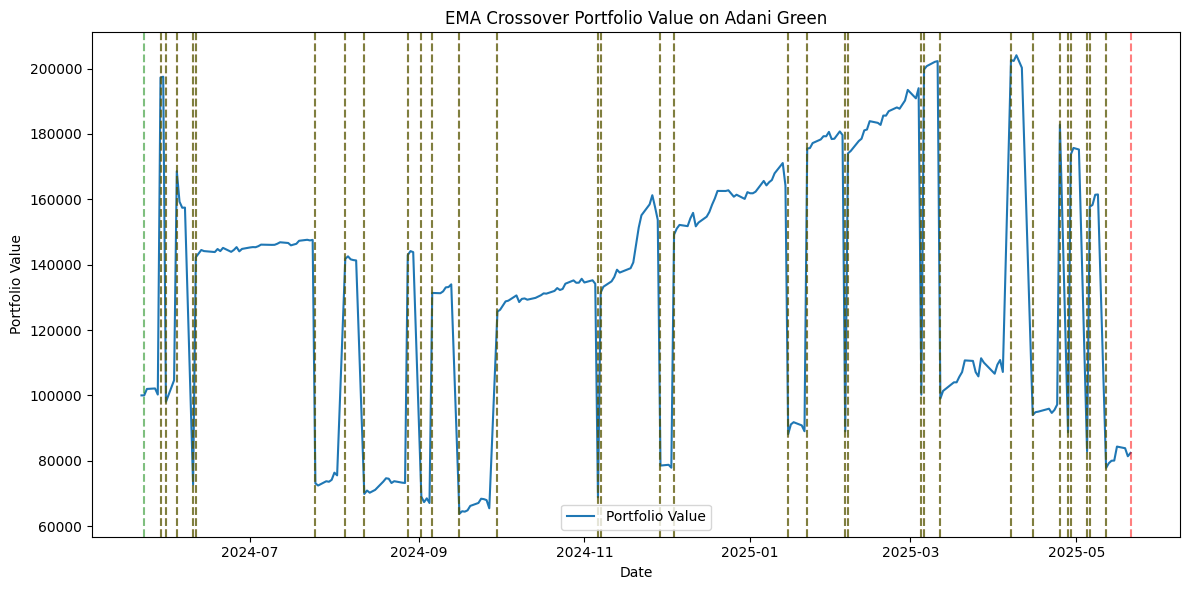


=== Running EMA Dynamic ATR Band on Adani Green ===
Net Profit (%)                : 6.87
Gross Profit (%)              : 56.08
Number of Trades              : 12.00
Winning Trades                : 3.00
Losing Trades                 : 9.00
Max Holding Time (days)       : 74.00
Avg Holding Time (days)       : 19.17
Max Drawdown (%)              : -62.85
Avg Drawdown (%)              : -24.82
Sharpe Ratio                  : 1.09


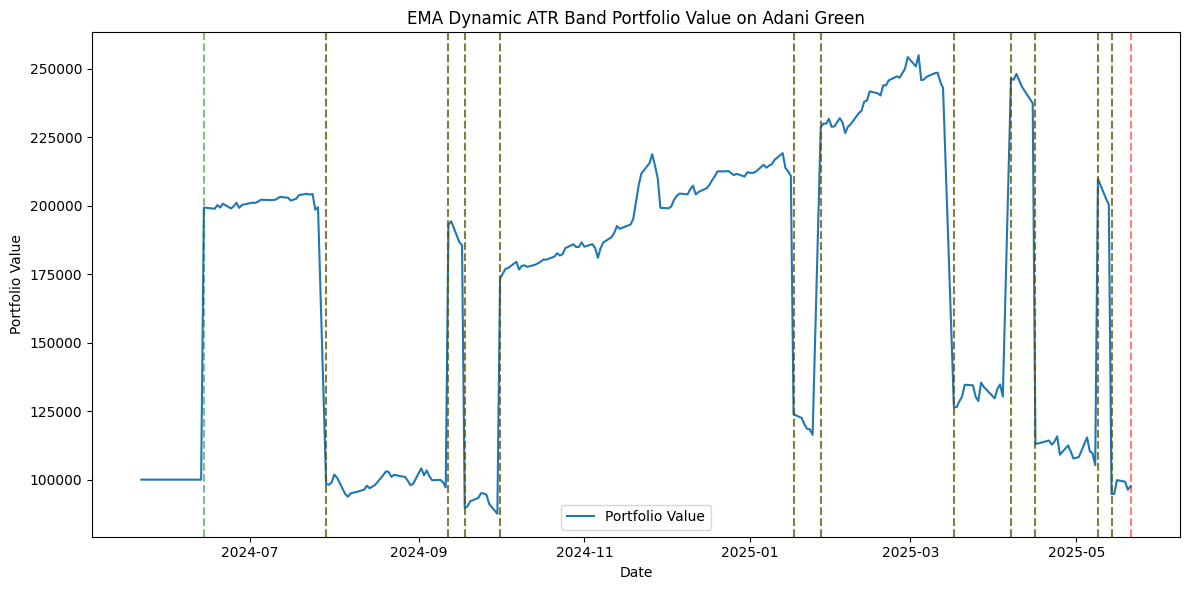


=== Running ATR Breakout on Adani Green ===
Net Profit (%)                : 46.69
Gross Profit (%)              : 51.64
Number of Trades              : 3.00
Winning Trades                : 2.00
Losing Trades                 : 1.00
Max Holding Time (days)       : 117.00
Avg Holding Time (days)       : 66.00
Max Drawdown (%)              : -48.25
Avg Drawdown (%)              : -12.72
Sharpe Ratio                  : 0.77


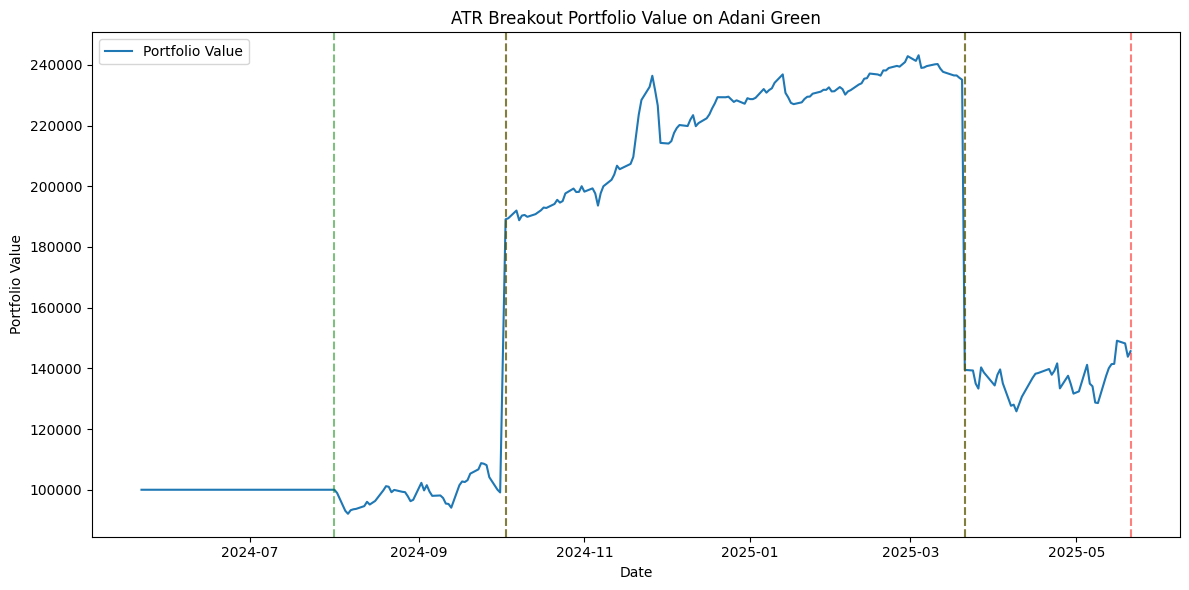


=== Running EMA Crossover on Bharat Electronics ===
Net Profit (%)                : 32.46
Gross Profit (%)              : 80.77
Number of Trades              : 27.00
Winning Trades                : 9.00
Losing Trades                 : 18.00
Max Holding Time (days)       : 27.00
Avg Holding Time (days)       : 9.11
Max Drawdown (%)              : -55.75
Avg Drawdown (%)              : -29.68
Sharpe Ratio                  : 1.70


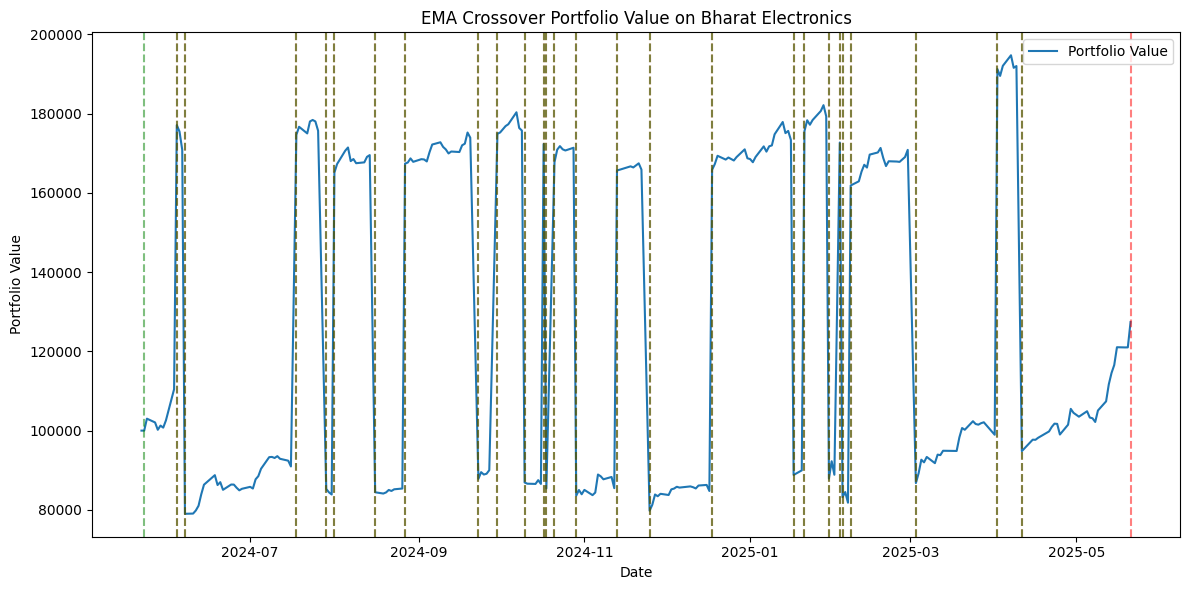


=== Running EMA Dynamic ATR Band on Bharat Electronics ===
Net Profit (%)                : -11.73
Gross Profit (%)              : 42.25
Number of Trades              : 13.00
Winning Trades                : 3.00
Losing Trades                 : 10.00
Max Holding Time (days)       : 49.00
Avg Holding Time (days)       : 18.38
Max Drawdown (%)              : -70.78
Avg Drawdown (%)              : -38.28
Sharpe Ratio                  : 1.06


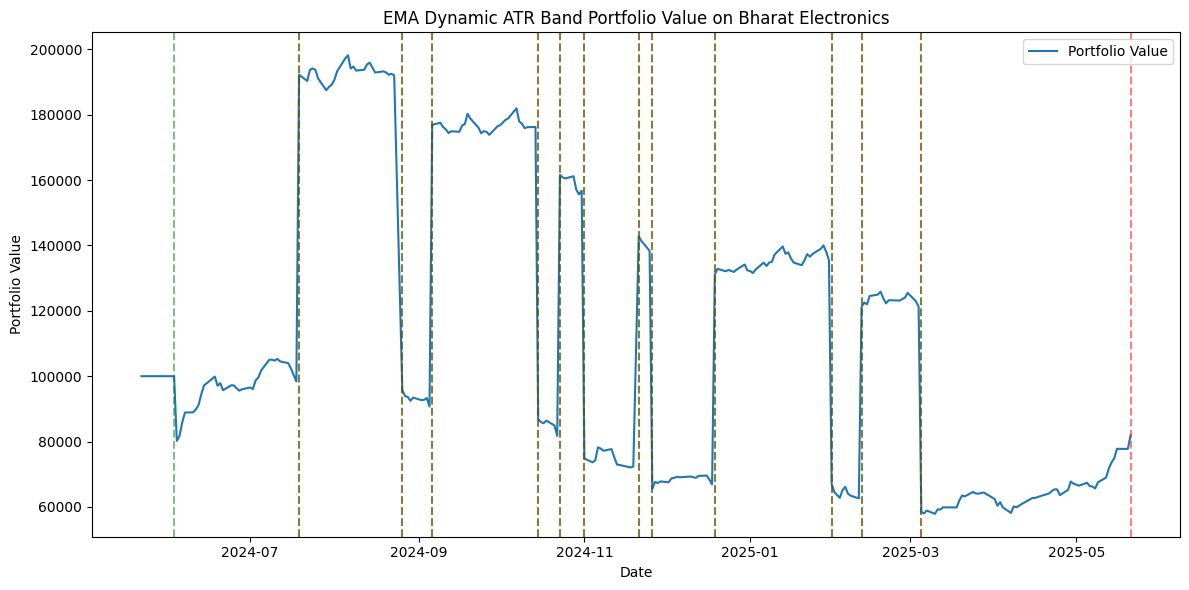


=== Running ATR Breakout on Bharat Electronics ===
Net Profit (%)                : -21.40
Gross Profit (%)              : 34.03
Number of Trades              : 7.00
Winning Trades                : 2.00
Losing Trades                 : 5.00
Max Holding Time (days)       : 43.00
Avg Holding Time (days)       : 30.86
Max Drawdown (%)              : -70.88
Avg Drawdown (%)              : -29.74
Sharpe Ratio                  : 0.67


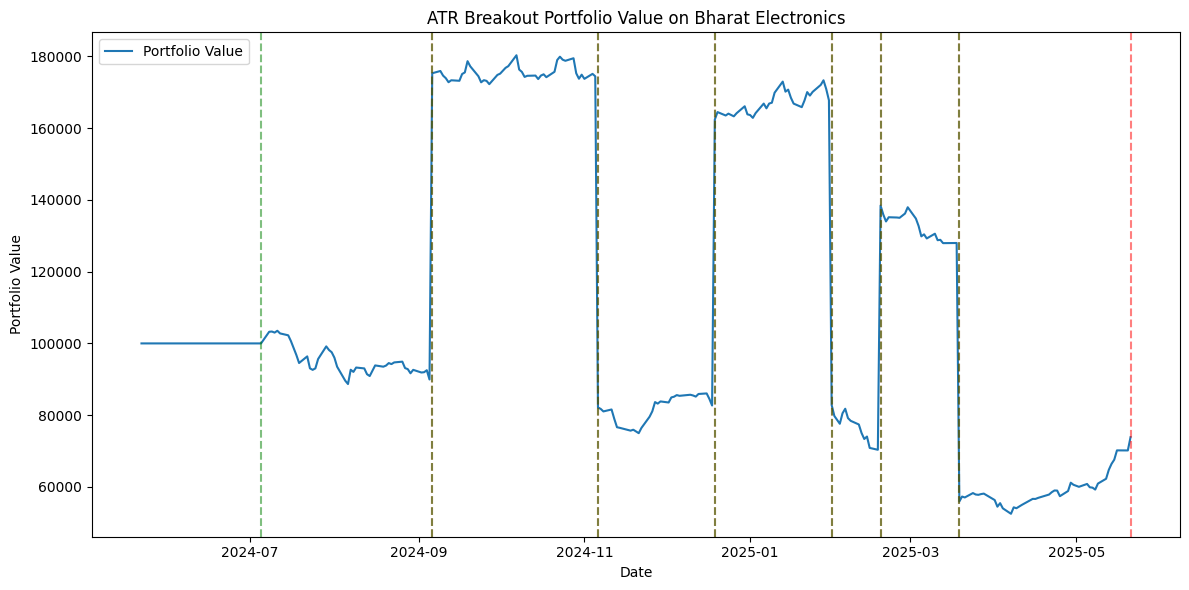

In [8]:
## === Run Strategies on Both Stocks ===

run_all_strategies(adani_green, 'Adani Green')
run_all_strategies(bharat_electronics_limited, 'Bharat Electronics')


In [9]:
vix = pd.read_csv('hist_india.csv')

In [10]:
vix.columns = vix.columns.str.strip()
vix['Date'] = pd.to_datetime(vix['Date'], format='%d-%b-%Y')
vix['Close'] = pd.to_numeric(vix['Close'], errors='coerce')

vix

,Date,Open,High,Low,Close,Prev. Close,Change,% Change
0,2024-05-22,21.8100,22.2925,18.1850,21.4675,21.8100,-0.34,-1.57
1,2024-05-23,21.4675,24.2150,18.8400,21.3800,21.4675,-0.09,-0.41
2,2024-05-24,21.3800,21.8975,20.5900,21.7100,21.3800,0.33,1.54
3,2024-05-27,21.7100,26.1950,18.4350,23.1925,21.7100,1.48,6.83
4,2024-05-28,23.1925,24.4750,22.0250,24.1950,23.1925,1.00,4.32
...,...,...,...,...,...,...,...,...
243,2025-05-15,17.2250,17.6725,16.7200,16.8900,17.2250,-0.34,-1.94
244,2025-05-16,16.8925,17.0550,16.2150,16.5500,16.8925,-0.34,-2.03
245,2025-05-19,16.5500,17.4475,15.8275,17.3600,16.5500,0.81,4.89
246,2025-05-20,17.3550,17.6600,15.9675,17.3900,17.3550,0.04,0.20


In [11]:
vix_mean = vix['Close'].mean()
vix_std = vix['Close'].std()

# Thresholds
threshold_1 = vix_mean + 0.5 * vix_std
threshold_2 = vix_mean + 1.5 * vix_std

print(f"VIX Mean: {vix_mean:.2f}")
print(f"VIX Std Dev: {vix_std:.2f}")
print(f"Threshold 1: {threshold_1:.2f}")
print(f"Threshold 2: {threshold_2:.2f}")


VIX Mean: 15.12
VIX Std Dev: 2.51
Threshold 1: 16.37
Threshold 2: 18.88


In [12]:
# Strategies

def ema_crossover(df):
    df = df.copy().reset_index(drop=True)

    # Ensure numeric and Series format
    close = df['Close'].astype(float)

    ema = close.ewm(span=14, adjust=False).mean()

    df['EMA'] = ema
    df['Signal'] = 0

    # Ensure alignment: close and ema are both Series with same index
    cond_buy = (close > ema) & (close.shift(1) <= ema.shift(1))
    cond_sell = (close < ema) & (close.shift(1) >= ema.shift(1))

    df.loc[cond_buy, 'Signal'] = 1
    df.loc[cond_sell, 'Signal'] = -1

    return df

def ema_dynamic_atr_band(df):
    df = df.copy().reset_index(drop=True)
    df['Close'] = df['Close'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)

    df['EMA'] = df['Close'].ewm(span=14, adjust=False).mean()
    df['Range'] = df['High'] - df['Low']

    df['BuyBand'] = df['EMA'] + df['Range']
    df['SellBand'] = df['EMA'] - df['Range']

    df['Signal'] = 0
    df.loc[df['Close'] > df['BuyBand'], 'Signal'] = 1
    df.loc[df['Close'] < df['SellBand'], 'Signal'] = -1

    return df


def compute_atr(df, period=14):
    df = df.copy()
    high = df['High'].astype(float)
    low = df['Low'].astype(float)
    close = df['Close'].astype(float)

    df['H-L'] = high - low
    df['H-PC'] = (high - close.shift()).abs()
    df['L-PC'] = (low - close.shift()).abs()
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=period).mean()
    return df['ATR']


def atr_breakout(df, k=1.5):
    df = df.copy().reset_index(drop=True)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['Close'] = df['Close'].astype(float)

    df['ATR'] = compute_atr(df)
    df['EMA'] = df['Close'].ewm(span=14, adjust=False).mean()

    df['BuyBand'] = df['EMA'] + k * df['ATR']
    df['SellBand'] = df['EMA'] - k * df['ATR']

    df['Signal'] = 0
    df.loc[df['Close'] > df['BuyBand'], 'Signal'] = 1
    df.loc[df['Close'] < df['SellBand'], 'Signal'] = -1

    return df


def dynamic_allocation(vix_value):
    if vix_value < threshold_1:
        return 1.0
    elif threshold_1 <= vix_value < threshold_2:
        return 0.75
    else:
        return 0.5

vix['Capital_Allocation'] = vix['Close'].apply(dynamic_allocation)


strategies = {
    'EMA Crossover': ema_crossover,
    'EMA Dynamic ATR Band': ema_dynamic_atr_band,
    'ATR Breakout': atr_breakout,
}


In [13]:
# Backtesting Engine

def backtest_with_dynamic_allocation(df, signal_col):
    position = 0
    entry_price = 0
    quantity = 0
    total_capital = 100000  # total capital fixed
    cash = total_capital    # cash available outside positions
    portfolio_value = []
    holdings = []
    trades = []
    daily_returns = []

    for i in range(len(df)):
        signal = df.loc[i, signal_col]
        close_price = df.loc[i, 'Close']
        alloc_pct = df.loc[i, 'Capital_Allocation']  # dynamic capital allocation fraction

        # Calculate the capital available for trading today
        alloc_capital = total_capital * alloc_pct

        # entering long
        if signal == 1 and position <= 0:
            # if currently short then exit short position
            if position == -1:
                exit_price = close_price
                ret = (entry_price - exit_price) / entry_price
                trades[-1].update({
                    'Exit Index': i,
                    'Exit Date': df.loc[i, 'Date'],
                    'Trade Duration': i - trades[-1]['Entry Index'],
                    'Returns (%)': ret * 100
                })
                # Buy back shares to close short
                cash -= quantity * exit_price
                quantity = 0
                position = 0

            # enter long with allocated capital
            # Adjust quantity based on allocated capital
            quantity = int(alloc_capital // close_price)
            if quantity > 0:
                cash -= quantity * close_price
                entry_price = close_price
                position = 1
                trades.append({
                    'Entry Index': i,
                    'Entry Date': df.loc[i, 'Date'],
                    'Exit Index': None,
                    'Exit Date': None,
                    'Trade Duration': None,
                    'Returns (%)': None,
                    'Type': 'Long',
                    'Quantity': quantity
                })

        # entering short
        elif signal == -1 and position >= 0:
            # if currently long then exit long position
            if position == 1:
                exit_price = close_price
                ret = (exit_price - entry_price) / entry_price
                trades[-1].update({
                    'Exit Index': i,
                    'Exit Date': df.loc[i, 'Date'],
                    'Trade Duration': i - trades[-1]['Entry Index'],
                    'Returns (%)': ret * 100
                })
                # Sell shares to close long
                cash += quantity * exit_price
                quantity = 0
                position = 0

            # enter short with allocated capital
            quantity = int(alloc_capital // close_price)
            if quantity > 0:
                cash += quantity * close_price
                entry_price = close_price
                position = -1
                trades.append({
                    'Entry Index': i,
                    'Entry Date': df.loc[i, 'Date'],
                    'Exit Index': None,
                    'Exit Date': None,
                    'Trade Duration': None,
                    'Returns (%)': None,
                    'Type': 'Short',
                    'Quantity': quantity
                })

        # Calculate portfolio value
        if position == 1:
            pv = cash + quantity * close_price
        elif position == -1:
            pv = cash + quantity * (entry_price - close_price)
        else:
            pv = cash

        portfolio_value.append(pv)
        holdings.append(quantity)

        # Calculate daily returns
        if i > 0:
            daily_returns.append((pv - portfolio_value[-2]) / portfolio_value[-2])
        else:
            daily_returns.append(0)

    # Close any open position at the end
    if position != 0:
        i = len(df) - 1
        close_price = df.loc[i, 'Close']
        if position == 1:
            ret = (close_price - entry_price) / entry_price
            cash += quantity * close_price
        else:
            ret = (entry_price - close_price) / entry_price
            cash -= quantity * close_price

        trades[-1].update({
            'Exit Index': i,
            'Exit Date': df.loc[i, 'Date'],
            'Trade Duration': i - trades[-1]['Entry Index'],
            'Returns (%)': ret * 100
        })

        portfolio_value[-1] = cash
        quantity = 0
        position = 0

    return daily_returns, portfolio_value, holdings, trades


In [14]:
def run_all_strategies_without_dynamic_allocation(df, name):
    for strat_name, strat_func in strategies.items():
        print(f"\n=== Running {strat_name} on {name} without dynamic allocation ===")
        strat_df = strat_func(df.copy())
        daily_returns, portfolio_value, holdings, trades = backtest(strat_df, 'Signal')

        daily_df = pd.DataFrame({
            'Date': strat_df['Date'],
            'Portfolio Value': portfolio_value,
            'Quantity': holdings,
            'Profit (%)': 100 * (np.array(portfolio_value) - 100000) / 100000
        })

        trade_df = pd.DataFrame(trades)
        trade_df['Entry Date'] = pd.to_datetime(trade_df['Entry Date'])
        trade_df['Exit Date'] = pd.to_datetime(trade_df['Exit Date'])
        daily_df['Date'] = pd.to_datetime(daily_df['Date'])
        portfolio_series = daily_df.set_index('Date')['Portfolio Value']

        compute_metrics(trade_df, daily_returns, portfolio_series)
        plot_portfolio(daily_df, trade_df, title=f'{strat_name} Portfolio Value on {name} without dynamic allocation')


def run_all_strategies_with_dynamic_allocation(df, name):
    for strat_name, strat_func in strategies.items():
        print(f"\n=== Running {strat_name} on {name} with dynamic allocation ===")
        strat_df = strat_func(df.copy())
        daily_returns, portfolio_value, holdings, trades = backtest_with_dynamic_allocation(strat_df, 'Signal')

        daily_df = pd.DataFrame({
            'Date': strat_df['Date'],
            'Portfolio Value': portfolio_value,
            'Quantity': holdings,
            'Profit (%)': 100 * (np.array(portfolio_value) - 100000) / 100000
        })

        trade_df = pd.DataFrame(trades)
        trade_df['Entry Date'] = pd.to_datetime(trade_df['Entry Date'])
        trade_df['Exit Date'] = pd.to_datetime(trade_df['Exit Date'])
        daily_df['Date'] = pd.to_datetime(daily_df['Date'])
        portfolio_series = daily_df.set_index('Date')['Portfolio Value']

        compute_metrics(trade_df, daily_returns, portfolio_series)
        plot_portfolio(daily_df, trade_df, title=f'{strat_name} Portfolio Value on {name} with dynamic allocation')


=== Running EMA Crossover on India_vix without dynamic allocation ===
Net Profit (%)                : -70.29
Gross Profit (%)              : 104.08
Number of Trades              : 43.00
Winning Trades                : 13.00
Losing Trades                 : 30.00
Max Holding Time (days)       : 23.00
Avg Holding Time (days)       : 5.72
Max Drawdown (%)              : -86.79
Avg Drawdown (%)              : -65.09
Sharpe Ratio                  : 2.10


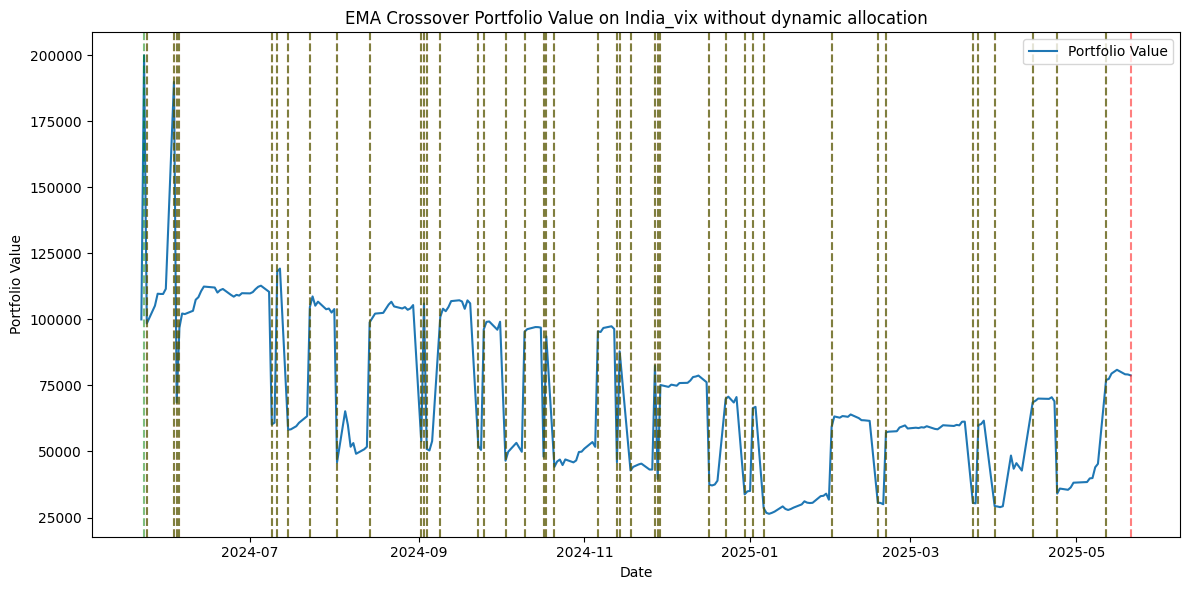


=== Running EMA Dynamic ATR Band on India_vix without dynamic allocation ===
Net Profit (%)                : -122.97
Gross Profit (%)              : 0.00
Number of Trades              : 6.00
Winning Trades                : 0.00
Losing Trades                 : 6.00
Max Holding Time (days)       : 160.00
Avg Holding Time (days)       : 40.33
Max Drawdown (%)              : -86.40
Avg Drawdown (%)              : -22.43
Sharpe Ratio                  : 0.46


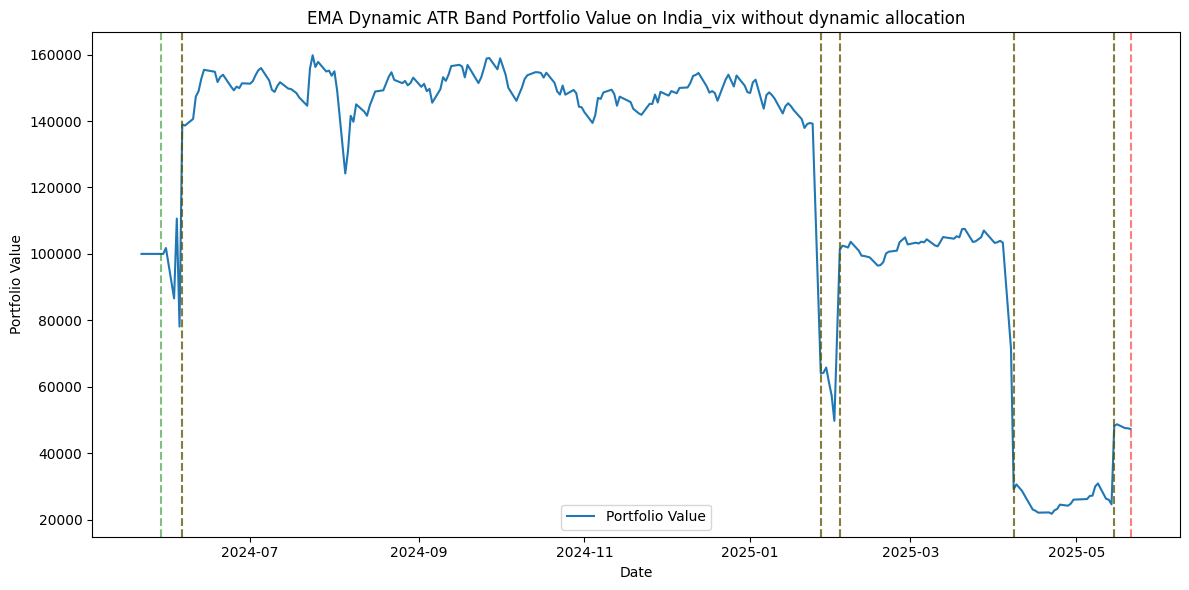


=== Running ATR Breakout on India_vix without dynamic allocation ===
Net Profit (%)                : -72.68
Gross Profit (%)              : 0.00
Number of Trades              : 2.00
Winning Trades                : 0.00
Losing Trades                 : 2.00
Max Holding Time (days)       : 196.00
Avg Holding Time (days)       : 115.00
Max Drawdown (%)              : -88.39
Avg Drawdown (%)              : -74.47
Sharpe Ratio                  : 0.25


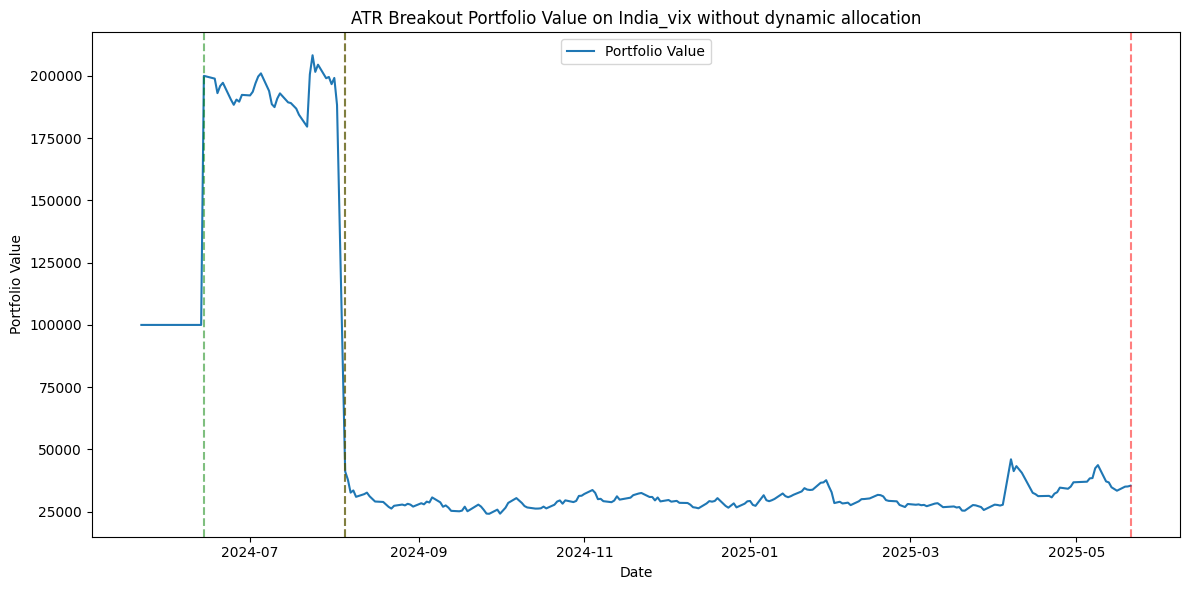


=== Running EMA Crossover on India_vix with dynamic allocation ===
Net Profit (%)                : -70.29
Gross Profit (%)              : 104.08
Number of Trades              : 43.00
Winning Trades                : 13.00
Losing Trades                 : 30.00
Max Holding Time (days)       : 23.00
Avg Holding Time (days)       : 5.72
Max Drawdown (%)              : -97.85
Avg Drawdown (%)              : -41.36
Sharpe Ratio                  : 2.97


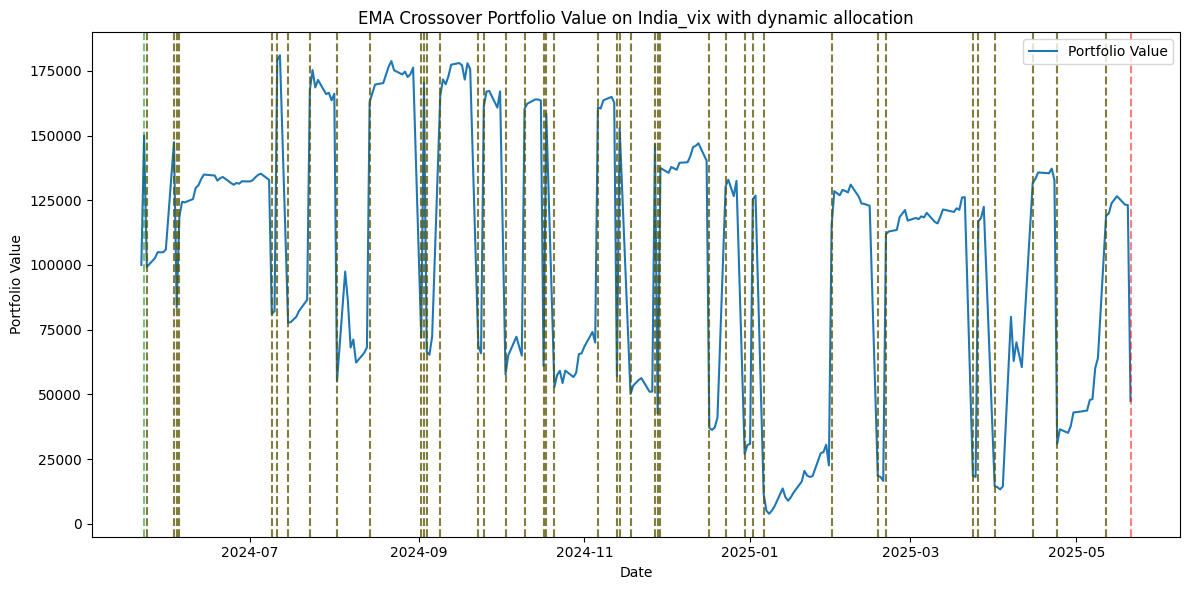


=== Running EMA Dynamic ATR Band on India_vix with dynamic allocation ===
Net Profit (%)                : -122.97
Gross Profit (%)              : 0.00
Number of Trades              : 6.00
Winning Trades                : 0.00
Losing Trades                 : 6.00
Max Holding Time (days)       : 160.00
Avg Holding Time (days)       : 40.33
Max Drawdown (%)              : -95.60
Avg Drawdown (%)              : -17.72
Sharpe Ratio                  : 1.00


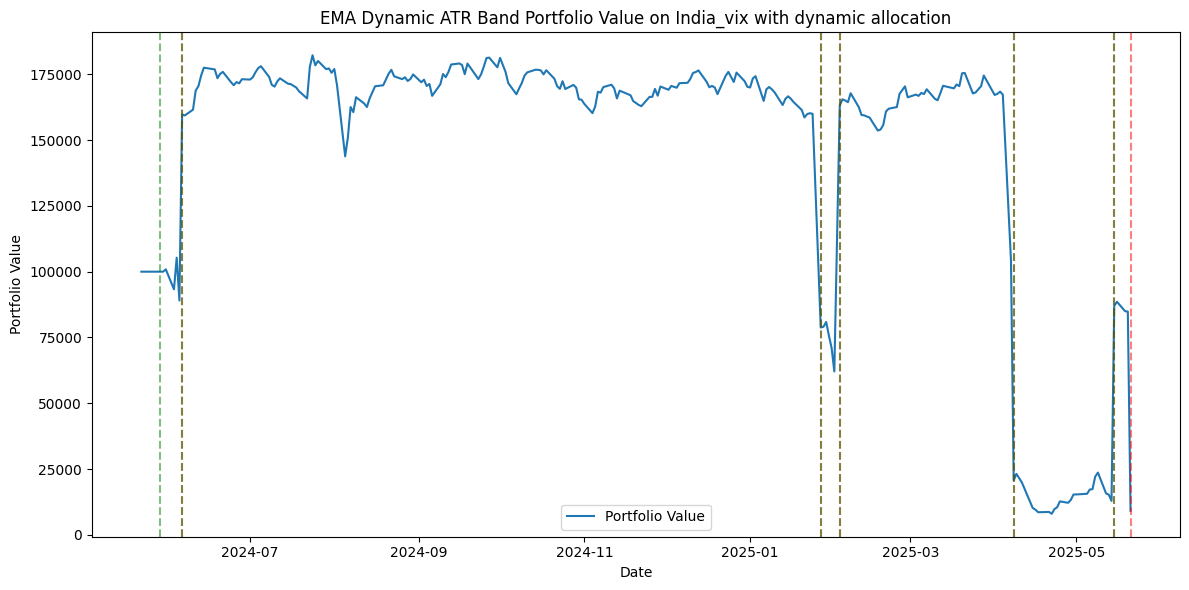


=== Running ATR Breakout on India_vix with dynamic allocation ===
Net Profit (%)                : -72.68
Gross Profit (%)              : 0.00
Number of Trades              : 2.00
Winning Trades                : 0.00
Losing Trades                 : 2.00
Max Holding Time (days)       : 196.00
Avg Holding Time (days)       : 115.00
Max Drawdown (%)              : -90.14
Avg Drawdown (%)              : -75.45
Sharpe Ratio                  : 0.35


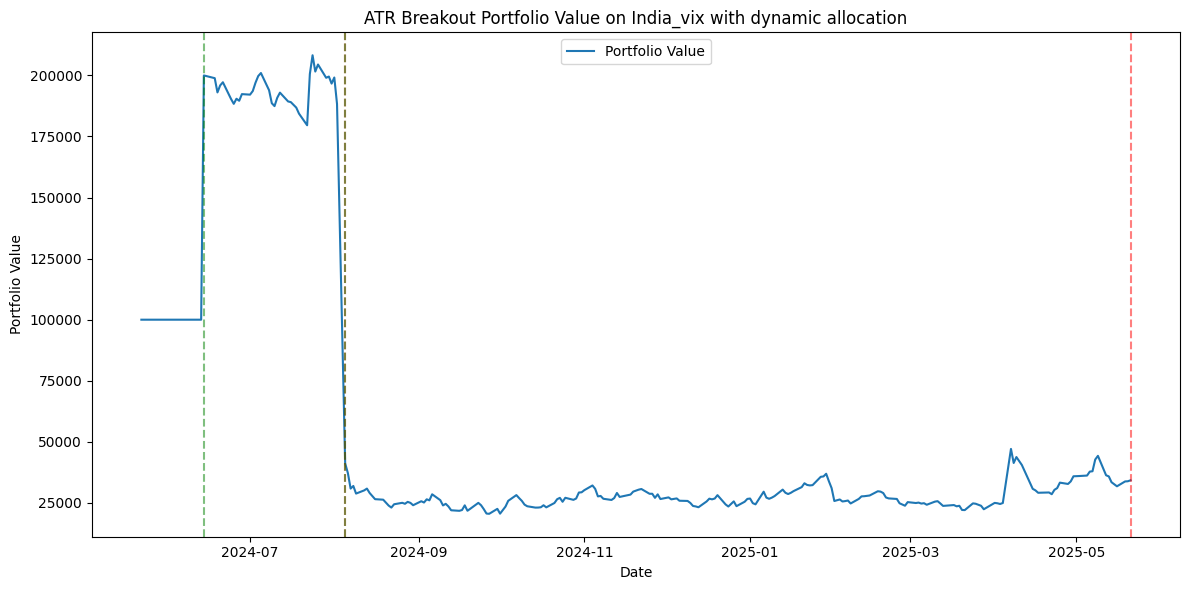

In [15]:
run_all_strategies_without_dynamic_allocation(vix, 'India_vix')
run_all_strategies_with_dynamic_allocation(vix, 'India_vix')